In [54]:
from __future__ import print_function, division
from builtins import range

In [55]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [56]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [57]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../content/drive/MyDrive/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  #/content/drive/MyDrive/glove.6B
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [58]:
train = pd.read_csv("../content/drive/MyDrive/nlu_dct.csv")
#sentences = train["examples"].fillna("DUMMY_VALUE").values
#possible_labels = ["locate_restaurant", "restaurant_type", "table_reservation", "restaurant_review"]
#targets = train[possible_labels].values
examples = train['examples'].values
intent = train['intent'].values


In [59]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(examples)
sequences = tokenizer.texts_to_sequences(examples)
#print("sequences:", sequences); exit()

In [60]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 66
min sequence length: 41
median sequence length: 57
max word index: 104


In [61]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 104 unique tokens.


In [62]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (4, 100)


In [63]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [64]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [65]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


print('Building model...')

Building model...


In [66]:
# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)
model.summary()

print('Training model...')
r = model.fit(
  data,
  intent,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 200)          21000     
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 98, 128)           76928     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 32, 128)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 10, 128)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 8, 128)            4928

ValueError: ignored

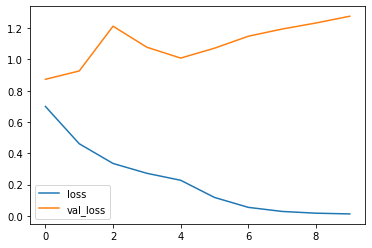

In [67]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

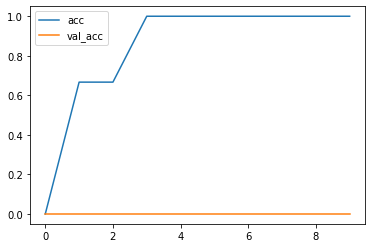

In [68]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [69]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

IndexError: ignored